In [ ]:
using GynC

#scalings = [2.0 ^ (i * 5/15) for i in -15:12]
#cs = map(x->Config(propvar=x*GynC.defaultpropvar), scalings)

#cs = Config[Config(Lausanne(p), propvar=1/8*GynC.defaultpropvar, adapt=true, thin=100) for p in 1:55]

cs = Config[Config(Lausanne(p), propvar=GynC.uniformpropvar(v), adapt=true, thin=100) for p in 1:5, v in [0.1, 0.01, 0.001]][:]

paths = map(c->joinpath("/nfs/datanumerik/bzfsikor/batch/",GynC.filename(c)), cs)

ss = map(GynC.load, paths)

In [2]:
ssf = map(ss) do s
    l = size(s.samples,1)
    s[20_000:100:l, :]
end

map(s->size(s.samples,1), ssf) |> sum

42453

In [3]:
using ClusterManagers
rmprocs(workers())
slurm = addprocs(SlurmManager(20))
@everywhere using GynC
@time w = WeightedChain(ssf)
rmprocs(slurm)

1249.617907 seconds (56.01 M allocations: 5.945 GB, 0.09% gc time)


:ok

In [12]:
JLD.save("merged.jld", "w", w)

In [108]:
using Plots, KernelDensity
plotsize=(600, 400*0.8)
iters = 20

  cols = linspace(colorant"midnightblue",colorant"lightskyblue", iters+1)
  cols = colormap("Blues", 1+2*iters)[iters+1:end]
  #cols[1] = colorant"red"

for species in 8#1:82
  ww = deepcopy(w)
  plot(legend=:none, title=GynC.samplednames[species], size=plotsize)
  for i=1:iters+1
      if i%1 == 0
          data = ww.samples[:,species]
          k = kde(data, npoints = 1000, weights = ww.weights, bandwidth=KernelDensity.default_bandwidth(data)/1)
          plot!(k.x, k.density, color=cols[i])
      end
      #emiteration!(ww)
      euler_phih!(ww, 0.001)
  end
  plot!() |> display
end

LoadError: LoadError: InterruptException:
while loading In[108], in expression starting on line 9

In [74]:
for species in 1:3
    species
    end


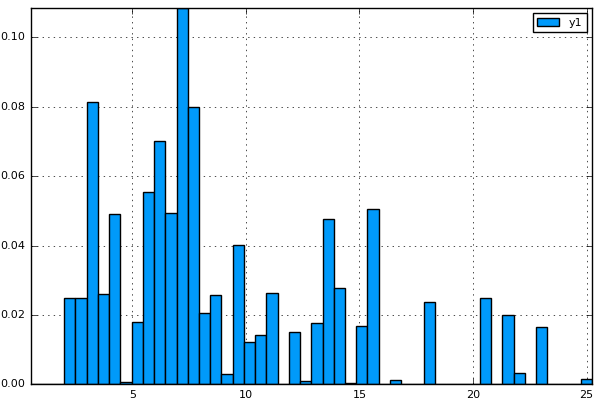

In [90]:
x, y = GynC.weightedhist(ww.samples[:,8], ww.weights, 50)

bar(x[1:end-1] + step(x),y)

In [110]:
euler_phih!(ww,0.1)

LoadError: LoadError: InterruptException:
while loading In[110], in expression starting on line 1